# Baseline LSTM MBTI Classification Model

First, load libraries and useful functions from class:

In [65]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import json, os, re, shutil, sys, time
from importlib import reload
import collections, itertools

# NumPy and TensorFlow
import numpy as np
import pandas as pd
import tensorflow as tf
assert(tf.__version__.startswith("1."))

# Utils and Helper libraries
# import nltk
from w266_common import utils, vocabulary
from sklearn.model_selection import train_test_split
import MBTI_data_setup as ds

## Load Corpus & Pre-Process

In [66]:
#load data
df = pd.read_csv('./mbti_1.csv')
df.head(5)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [67]:
reload(ds)
post, mbti_type, user = ds.splitPosts(df)

# Split data: 80% train, 20% test
post_train, post_test, label_train, label_test = train_test_split(post, mbti_type, test_size=0.2, random_state=88)

print("MBIT posts", post_train[:5])
print('')
print("MBTI Labels: ",label_train[:5])

# Build a vocabulary (V size is defaulted to full text) for train corpus
vocab_mbti = vocabulary.Vocabulary((utils.canonicalize_word(w) for w in post_train))
print("Vocab Size: ",vocab_mbti.size)

# tokenize and canonicalize train and test sets
x_train = []
for post in post_train:
    x_train.append(vocab_mbti.words_to_ids(post.split()))

x_test = []
for post in post_test:
    x_test.append(vocab_mbti.words_to_ids(post.split()))
    
reload(ds)
y_train, y_test = ds.one_hot_label(mbti_type, label_train, label_test)
y_train_id, y_test_id, label_map = ds.label_to_id(mbti_type, label_train, label_test)

print(y_train_id[:2])
print(y_test_id[:2])
print(y_train[:2])
print(y_test[:2])

(422845, 3)
MBIT posts ['https://www.youtube.com/watch?v=bxvkaah2d7m'
 'isfjs and infps can balance each other really well, i think, if they learn to communicate - sjs choosing words (and tone of voice!) carefully, and nps learning to take things less personally. your sj...'
 "i'd seek recognition. not fame."
 "to be honest, maybe you are giving out vibes that you are not self-assured. because if you think about it, a bully is going to go for someone they don't think will fight back, someone who is weak (i..."
 "probably. any thinking, really. personally, i prefer the ax-b-c-dy function stack compared to grant's. it allows for the parts where grant gets it right while still being consistent with jung, i.e.,..."]

MBTI Labels:  ['INTP' 'INFP' 'INTP' 'ENFP' 'INTJ']
Vocab Size:  333007
[ 2 12]
[12  0]
[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


## Bulid the LSTM Model

In [68]:
# Model Parameters
V = vocab_mbti.size
classes = 16 #len(set(labels))
batch_size = 25
text_length = 70 # max sentence is 66
embed_dim = 50 #256
hidden_dims = 100 #
num_layers = 1

# Training Parameters
dropout_keep_prob = .5
softmax_ns = 4
learning_rate = .001
num_epochs = 5

In [69]:
# useful functions for building LSTM
def MakeFancyRNNCell(hidden_dims, keep_prob, layers=1, isTrain=True):
    """Make a fancy RNN cell.

    Use tf.nn.rnn_cell functions to construct an LSTM cell.
    Initialize forget_bias=0.0 for better training.

    Args:
      H: hidden state sizes, provided in array
      keep_prob: dropout keep prob (same for input and output)

    Returns:
      (tf.nn.rnn_cell.RNNCell) multi-layer LSTM cell with dropout
    """
    if isTrain == False:
        keep_prob = 1.0

    cells = []
    for _ in range(layers):
#         cell = tf.nn.rnn_cell.BasicLSTMCell(H, forget_bias=0.0) #deprecated?
        cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_dims, forget_bias=0.0,state_is_tuple=True)
        cell = tf.nn.rnn_cell.DropoutWrapper(cell, 
                                             input_keep_prob=keep_prob, 
                                             output_keep_prob=keep_prob)
        cells.append(cell)
    return tf.nn.rnn_cell.MultiRNNCell(cells)


In [70]:
tf.reset_default_graph()
tf.set_random_seed(88)
    
# Create input placeholder
with tf.name_scope("Inputs"):
    x_text_ = tf.placeholder(tf.int32, [None, None], name="x_text") #batch x text_length
    y_type_ = tf.placeholder(tf.int32, [None,classes], name="y_type") #batch x classes

    
# Model params
with tf.name_scope("Dynamic_Params"):
    # Get dynamic shape info from inputs
    batch_size_ = tf.shape(x_text_)[0]
    text_length_ = text_length
    ns_ = tf.tile([text_length], [batch_size_, ], name="ns")
    isTrain_ = tf.placeholder(tf.bool, shape=())

# Construct embedding layer
with tf.name_scope("Embedding_Layer"):
#     W_in_ = tf.get_variable(tf.random_uniform(-1.0, 1.0),shape=[V, embed_dim], name="W_in")
    W_in_ = tf.Variable(tf.random_uniform([V, embed_dim], -1.0, 1.0), name="W_in")
    x_ = tf.nn.embedding_lookup(W_in_, x_text_,name='x')
    print("Embedded Input: ", x_.shape)

# Construct RNN/LSTM cell and recurrent layer.
with tf.name_scope("Recurrent_Layer"):
    cell_lstm_ = MakeFancyRNNCell(hidden_dims, dropout_keep_prob, num_layers,isTrain_)
    initial_h_ = cell_lstm_.zero_state(batch_size_, dtype=tf.float32)
    output_, final_h_= tf.nn.dynamic_rnn(cell=cell_lstm_, inputs=x_, 
                                         sequence_length= ns_, initial_state = initial_h_, dtype=tf.float32)
    print("LSTM Cell output shape: ",output_.shape)

with tf.name_scope("Output_Layer"):
    h_ = tf.reduce_sum(output_, 1)
    fully_connected_ = tf.layers.dense(h_, hidden_dims, activation=tf.tanh)
    fc_do_ = tf.layers.dropout(inputs=fully_connected_, rate=(1-dropout_keep_prob), training=isTrain_)
    if isTrain_==True:
        fully_connected_ = fc_do_
    print("fully connected output shape: ",fully_connected_.shape)
    W_out_ = tf.Variable(tf.random_uniform([int(fully_connected_.shape[1]),classes],-1.0, 1.0), name="W_out")
    print("W_out: ",W_out_.shape)
    b_out_ = tf.Variable(tf.zeros([classes,], dtype=tf.float32), name="b_out")
    logits_ = tf.add(tf.matmul(fully_connected_,W_out_), b_out_, name="logits")
    print("Logits: ",logits_.shape)
    
#     output_ = tf.reshape(output_, [batch_size_,text_length*hidden_dims])
#     print("flattened output shape: ",output_.shape)
#     W_out_ = tf.Variable(tf.random_uniform([hidden_dims*text_length,classes],-1.0, 1.0), name="W_out")
#     print("W_out: ",W_out_.shape)
#     b_out_ = tf.Variable(tf.zeros([classes,], dtype=tf.float32), name="b_out")
#     logits_ = tf.add(tf.matmul(output_,W_out_), b_out_, name="logits")
#     print("Logits: ",logits_.shape)

        

with tf.name_scope("Cost_Function"):
    # Full softmax loss for training / scoring
    per_example_loss_ = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_type_, 
                                                                   logits=logits_,
                                                                   name="per_example_loss")
    loss_ = tf.reduce_mean(per_example_loss_, name="loss")
    
    # Sampled softmax for training
    train_inputs_ = tf.reshape(output_, [batch_size_*text_length_,-1])

    per_example_sampled_softmax_loss_ = tf.nn.sampled_softmax_loss(weights=tf.transpose(W_out_),
                                                                   biases=b_out_,
                                                                   labels=tf.reshape(y_type_, [-1, 1]),
                                                                   inputs=train_inputs_,
                                                                   num_sampled=softmax_ns, 
                                                                   num_classes=classes,
                                                                   name="per_example_sampled_softmax_loss")

    sampled_softmax_loss_ = tf.reduce_mean(per_example_sampled_softmax_loss_, name="sampled_softmax_loss")
    
with tf.name_scope("Prediction"):
    pred_proba_ = tf.nn.softmax(logits_, name="pred_proba")
    pred_max_ = tf.argmax(logits_, 1, name="pred_max")
    pred_random_ = tf.reshape(tf.multinomial(tf.reshape(logits_ , [-1, classes]), 
                                                          1, 
                                                          output_dtype=tf.int32, 
                                                          name="pred_random"),
                                           [batch_size_,1])
    print("Pred Prob Shape: ",pred_proba_.shape)
    print("Pred Max Shape: ",pred_max_.shape)
    print("Sampling Shape: ",pred_random_.shape)

    
with tf.name_scope("Train"):
    learning_rate_ = tf.placeholder(tf.float32, name="learning_rate")
    optimizer_ = tf.train.AdamOptimizer(learning_rate_)
    gradients, variables = zip(*optimizer_.compute_gradients(loss_))
    gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
    train_step_ = optimizer_.apply_gradients(zip(gradients, variables))

# Initializer step
init_ = tf.global_variables_initializer()

Embedded Input:  (?, ?, 50)
LSTM Cell output shape:  (?, ?, 50)
fully connected output shape:  (?, 50)
W_out:  (50, 16)
Logits:  (?, 16)
Pred Prob Shape:  (?, 16)
Pred Max Shape:  (?,)
Sampling Shape:  (?, 1)


In [71]:
# w
summary_writer = tf.summary.FileWriter("tf_graph", tf.get_default_graph())

## Train Model

In [72]:
# create batched arrays of size batch_size based on input x and input y
def pad_np_array(example_ids, max_len=text_length, pad_id=0):
    arr = np.full([len(example_ids), max_len], pad_id, dtype=np.int32)
    ns = np.zeros([len(example_ids)], dtype=np.int32)
    for i, ids in enumerate(example_ids):
        cpy_len = min(len(ids), max_len)
        arr[i,:cpy_len] = ids[:cpy_len]
        ns[i] = cpy_len
    return arr, ns

def batch_generator(x, y, batch_size):
    for i in range(0, len(x), batch_size):
        # padd the batch
        x_batch = x[i:i+batch_size]
        x_padded, _ = pad_np_array(x_batch, max_len=text_length, pad_id=0)
        yield (x_padded, y[i:i+batch_size]) # returns tuple of batched x, batched y

def train_batch(session, xbatch, ybatch, learning_rate):
    feed_dict = {x_text_:xbatch, #np array of texts
                 y_type_:ybatch, #np array of types
                 learning_rate_:learning_rate}
#     c, _ = session.run([sampled_softmax_loss_, train_step_],
    c, _ = session.run([loss_, train_step_],
                       feed_dict=feed_dict)
    return c

In [73]:
print_interval = 1000

np.random.seed(88)

session = tf.Session()
session.run(init_)

t0 = time.time()
# open('results/MBTI16_LSTM_baseline_100HD_pilot1000.txt', 'w').close()
# with open('results/MBTI16_LSTM_baseline_100HD_pilot1000.txt', 'a') as f:
#     f.write('TRAINING PILOT 1000 \n')
#     for epoch in range(1,num_epochs+1):
#         t0_epoch = time.time()
#         epoch_cost = 0.0
#         total_batches = 0
#         print ("")
#         for i, (x,y) in enumerate(batch_generator(x_train[:1000], y_train[:1000], batch_size)): # for pilot
#             if (i % print_interval == 0):
#                 print("[epoch %d] seen %d batches" % (epoch, i))

#             epoch_cost += train_batch(session, x, y, learning_rate)
#             total_batches = i + 1

#         avg_cost = epoch_cost / total_batches
#         f.write("[epoch %d] Completed %d batches in %s" % (epoch, i, utils.pretty_timedelta(since=t0_epoch)) +'\n')
#         f.write("[epoch %d] Average cost: %.03f" % (epoch, avg_cost,)+'\n')
#         print("[epoch %d] Completed %d batches in %s" % (epoch, i, utils.pretty_timedelta(since=t0_epoch)))
#         print("[epoch %d] Average cost: %.03f" % (epoch, avg_cost,))
        
# open('results/MBTI16_LSTM_baseline_100HD_pilot5000.txt', 'w').close()
# with open('results/MBTI16_LSTM_baseline_100HD_pilot5000.txt', 'a') as f:
#     f.write('TRAINING PILOT 5000 \n')
#     for epoch in range(1,num_epochs+1):
#         t0_epoch = time.time()
#         epoch_cost = 0.0
#         total_batches = 0
#         print ("")
#         for i, (x,y) in enumerate(batch_generator(x_train[:5000], y_train[:5000], batch_size)): # for pilot
#             if (i % print_interval == 0):
#                 print("[epoch %d] seen %d batches" % (epoch, i))

#             epoch_cost += train_batch(session, x, y, learning_rate)
#             total_batches = i + 1

#         avg_cost = epoch_cost / total_batches
#         f.write("[epoch %d] Completed %d batches in %s" % (epoch, i, utils.pretty_timedelta(since=t0_epoch)) +'\n')
#         f.write("[epoch %d] Average cost: %.03f" % (epoch, avg_cost,)+'\n')
#         print("[epoch %d] Completed %d batches in %s" % (epoch, i, utils.pretty_timedelta(since=t0_epoch)))
#         print("[epoch %d] Average cost: %.03f" % (epoch, avg_cost,))

open('results/MBTI16_LSTM_baseline_100HD.txt', 'w').close()
with open('results/MBTI16_LSTM_baseline_100HD.txt', 'a') as f:
    f.write('TRAINING Full \n')
    for epoch in range(1,num_epochs+1):
        t0_epoch = time.time()
        epoch_cost = 0.0
        total_batches = 0
        print ("")
        for i, (x,y) in enumerate(batch_generator(x_train, y_train, batch_size)):
            if (i % print_interval == 0):
                print("[epoch %d] seen %d batches" % (epoch, i))

            epoch_cost += train_batch(session, x, y, learning_rate)
            total_batches = i + 1

        avg_cost = epoch_cost / total_batches
        f.write("[epoch %d] Completed %d batches in %s" % (epoch, i, utils.pretty_timedelta(since=t0_epoch)) +'\n')
        f.write("[epoch %d] Average cost: %.03f" % (epoch, avg_cost,)+'\n')
        print("[epoch %d] Completed %d batches in %s" % (epoch, i, utils.pretty_timedelta(since=t0_epoch)))
        print("[epoch %d] Average cost: %.03f" % (epoch, avg_cost,))


[epoch 1] seen 0 batches
[epoch 1] Completed 199 batches in 0:00:36
[epoch 1] Average cost: 3.547

[epoch 2] seen 0 batches
[epoch 2] Completed 199 batches in 0:00:35
[epoch 2] Average cost: 2.573

[epoch 3] seen 0 batches
[epoch 3] Completed 199 batches in 0:00:35
[epoch 3] Average cost: 2.367

[epoch 4] seen 0 batches
[epoch 4] Completed 199 batches in 0:00:30
[epoch 4] Average cost: 2.305

[epoch 5] seen 0 batches
[epoch 5] Completed 199 batches in 0:00:30
[epoch 5] Average cost: 2.276


## Evaluate Model

In [74]:
def predict_type(session,x):
    inputs = {x_text_:x,#np array of texts
             isTrain_: False} 
    pred = session.run([pred_max_],feed_dict=inputs)
    return pred # batch x 1

In [75]:
# Accuracy on train set
train_accuracy=[]
preds = []

# # pilot 1K
# with open('results/MBTI16_LSTM_baseline_100HD_pilot1000.txt', 'a') as f:
#     for i, (x,y) in enumerate(batch_generator(x_train[:1000], y_train_id[:1000], batch_size)):

# # pilot 5k
# with open('results/MBTI16_LSTM_baseline_100HD_pilot5000.txt', 'a') as f:
#     for i, (x,y) in enumerate(batch_generator(x_train[:5000], y_train_id[:5000], batch_size)): 

# Full
with open('results/MBTI16_LSTM_baseline_100HD.txt', 'a') as f:
    for i, (x,y) in enumerate(batch_generator(x_train, y_train_id, batch_size)):
        pred = predict_type(session,x)
        train_accuracy.append((pred[0] == y).mean())
        preds.append(pred[0])
    f.write("Train accuracy: " +str(float(np.mean(train_accuracy)))+'\n')
    print("Train accuracy: " ,np.mean(train_accuracy))
    # print samples
    f.write("Train Samples: \n")
    for i, sentence in enumerate(post_train[:10]):
        f.write("(%s) %s \n pred:%s \n actual:%s \n" % (i,sentence,preds[0][i-1],y_train_id[i-1]))

Train accuracy:  0.212


In [76]:
# Accuray on test set
test_accuracy = []
preds = []

# # Pilot 1K
# with open('results/MBTI16_LSTM_baseline_100HD_pilot1000.txt', 'a') as f:
#     for i, (x,y) in enumerate(batch_generator(x_test[:200], y_test_id[:200], batch_size)):

# # Pilot 5K
# with open('results/MBTI16_LSTM_baseline_100HD_pilot5000.txt', 'a') as f:
#     for i, (x,y) in enumerate(batch_generator(x_test[:1000], y_test_id[:1000], batch_size)):

# Full
with open('results/MBTI16_LSTM_baseline_100HD.txt', 'a') as f:
    for i, (x,y) in enumerate(batch_generator(x_test, y_test_id, batch_size)):
        pred = predict_type(session,x)
        test_accuracy.append((pred[0] == y).mean())
        preds.append(pred[0])
    f.write("Test accuracy: " +str(float(np.mean(test_accuracy)))+'\n')
    print("Test accuracy: " +str(float(np.mean(test_accuracy))))
    f.write("Test Samples: \n")
    for i, sentence in enumerate(post_test[:10]):
        f.write("(%s) %s \n pred:%s \n actual:%s \n" % (i,sentence,preds[0][i],y_test_id[i]))

Test accuracy: 0.203


In [77]:
def score_batch(session, x, y):
    feed_dict = {x_text_:x,
                 y_type_:y}
    return session.run(loss_, feed_dict=feed_dict)

def score_dataset(x, y):
    total_cost = 0.0
    total_batches = 0
    for (x,y) in batch_generator(x, y, 5):
        total_cost += score_batch(session, x, y)
        total_batches += 1

    return total_cost / total_batches

In [78]:
# #for pilot 1K
# train_perp = np.exp(score_dataset(x_train[:1000],y_train[:1000]))
# test_perp = np.exp(score_dataset(x_test[:200],y_train[:200]))
# print ("Train set perplexity: %.03f" % train_perp)
# print ("Test set perplexity: %.03f" % test_perp)
# with open('results/MBTI16_LSTM_baseline_100HD_pilot1000.txt', 'a') as f:
#     f.write("Train set perplexity: %.03f \n" % train_perp)
#     f.write("Test set perplexity: %.03f" % test_perp)
    
    
# # for pilot 5K
# train_perp = np.exp(score_dataset(x_train[:5000],y_train[:5000]))
# test_perp = np.exp(score_dataset(x_test[:1000],y_train[:1000]))
# print ("Train set perplexity: %.03f" % train_perp)
# print ("Test set perplexity: %.03f" % test_perp)
# with open('results/MBTI16_LSTM_baseline_100HD_pilot5000.txt', 'a') as f:
#     f.write("Train set perplexity: %.03f \n" % train_perp)
#     f.write("Test set perplexity: %.03f" % test_perp)
    

# Full
train_perp = np.exp(score_dataset(x_train,y_train))
test_perp = np.exp(score_dataset(x_test,y_test))
print ("Train set perplexity: %.03f" % train_perp)
print ("Test set perplexity: %.03f" % test_perp)
with open('results/MBTI16_LSTM_baseline_100HD.txt', 'a') as f:
    f.write("Train set perplexity: %.03f \n" % train_perp)
    f.write("Test set perplexity: %.03f \n" % test_perp)


Train set perplexity: 9.653
Test set perplexity: 9.736


Confusion matrix, without normalization
[[  0   0   1   0   0   0   0   0   0   0   0   1 178   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  37   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0 142   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  75   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  22   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 134   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  33   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  41   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0  20   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  10   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  16   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0  69   0   0   0]
 [  1   0   1   0   0   0   0   0   0   0   0   0 202   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   7   0   0   0]
 [  0   0   0   0   0 

<Figure size 432x288 with 0 Axes>

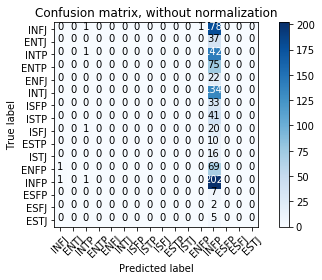

In [89]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


class_names = label_map.keys()

# Compute confusion matrix
test_predictions = np.array(preds).flatten()
true = y_test_id
cnf_matrix = confusion_matrix(true,test_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig1 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()
fig1.savefig('results/mbti16-baseline-100HD-confusion.png')

# Plot normalized confusion matrix
fig2 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
fig2.savefig('results/mbti16-baseline-100D-confusion-norm.png')